In [1]:
using Revise
includet("../../scripts/mm_Kl_pds.jl")

┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Symbolics → SymbolicsForwardDiffExt
│  └─ Symbolics → SymbolicsPreallocationToolsExt
│ Precompilation will also be skipped for the following, which depend on the above cycle:
│   SSMC
│   MLSolver
└ @ Pkg.API.Precompilation ~/.julia/juliaup/julia-1.10.10+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/precompilation.jl:583
Precompiling packages...
  13671.4 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 17 seconds. 540 already precompiled. 4 skipped due to circular dependency.


In [2]:
using OhMyThreads
using ProgressMeter
using JLD2
using ColorSchemes

In [3]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

  0.114331 seconds (12.43 M allocations: 753.752 MiB, 0.00% compilation time)


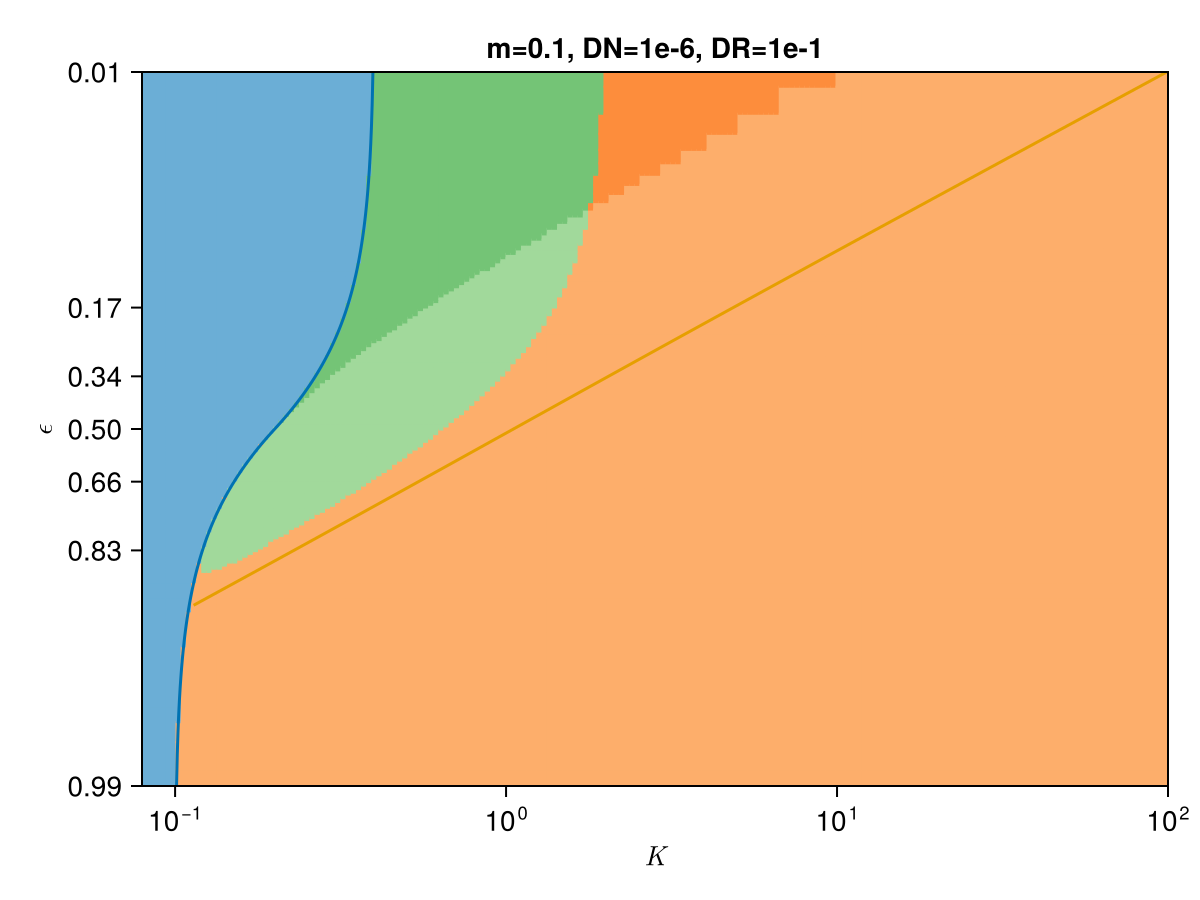

In [116]:
@time f = make_Kl_pd(
    range(-1.1, 2., 200), range(0.01, 0.99, 200),
    # 0.9, 0.9,
    # 1.0, 1.0,
    0.1, 1.0,
    1e-6, 1., 1e-1,
)
# f.axis.title = "DN=1e-14"
# f.axis.title = "DN=1e-6"
f.axis.title = "m=0.1, DN=1e-6, DR=1e-1"
Makie.save("../../figures/fig2/extras/lowm_midDN_lowDR.pdf", f)
f

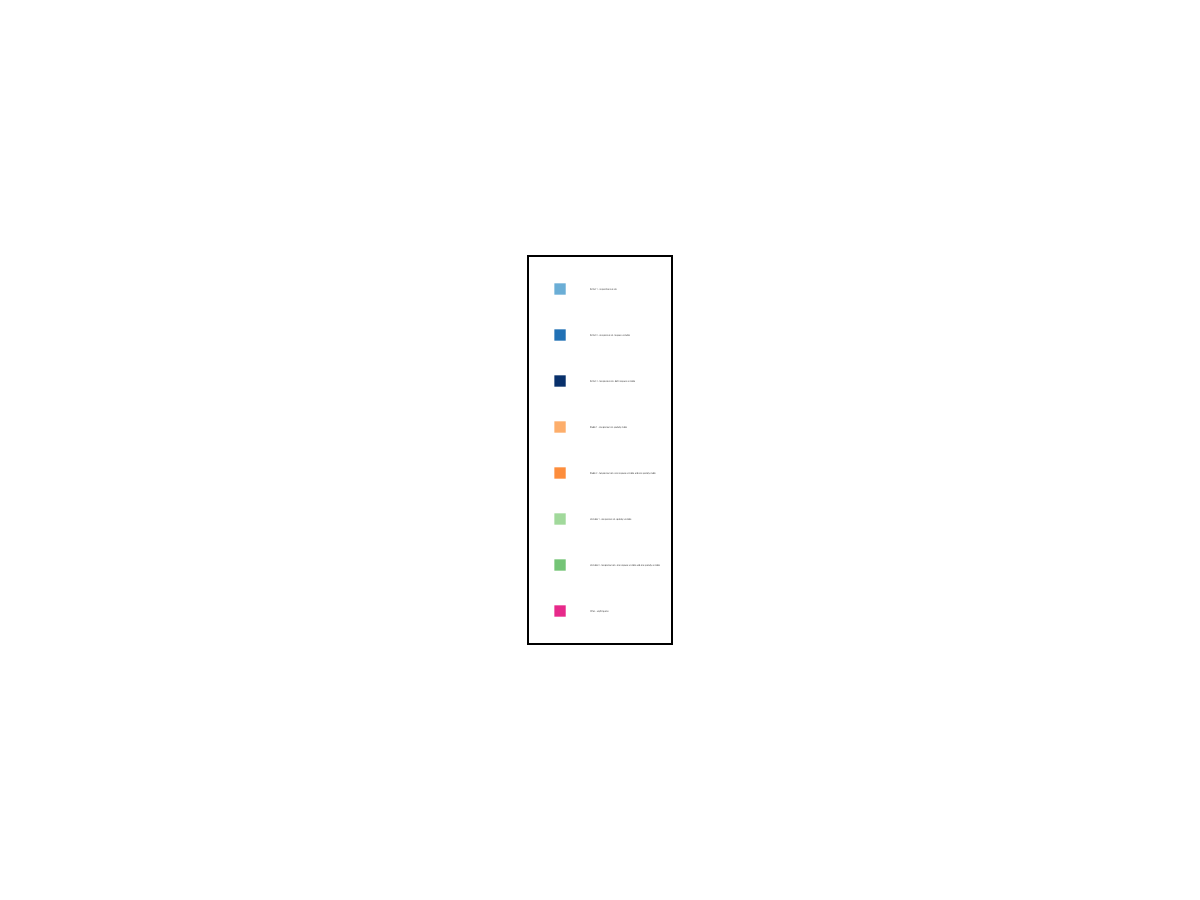

In [39]:
fig = Figure()
make_Kl_pd_legend_full!(fig[1,1]; labelsize=1)

fig

# OLD

# OLD

# OLD

# OLD

# Phase diagrams

In [21]:
logKs=range(-0.5, 4, 800),
leak_xs=range(-5, 5, 300),
DI=1.,
DR=1.,

f = make_Kl_pd()
f.axis.title = L"m=1, D_R=D_I"
f.axis.titlegap = 2.
@time Makie.save("../../figures/fig2/Kl_pd_base.pdf", f.figure)

f = make_Kl_pd(m=10., DR=0.5)
f.axis.title = L"m=10, D_R=\frac{D_I}{2}"
f.axis.titlegap = 2.
@time Makie.save("../../figures/fig2/Kl_pd_both.pdf", f.figure)

  0.740442 seconds (471.63 k allocations: 44.587 MiB, 60.15% compilation time)
  0.283947 seconds (50.69 k allocations: 15.916 MiB)


CairoMakie.Screen{PDF}


# Diffusion heatmap

## Generate data

In [98]:
DIs = 10 .^ range(-12, 1, 30)
DRs = 10 .^ range(-12, 1, 30)

logKs=range(-0.5, 4, 100)
leak_xs=range(-5, 5, 100)
ls = LeakageScale.l.(leak_xs)

props = Matrix{Float64}(undef, length(DIs), length(DRs))
pb = Progress(length(props))
for i in 1:length(DIs)
    for j in 1:length(DRs)
        rslts = Matrix{Any}(undef, length(logKs), length(ls))
        @tasks for Ki in 1:length(logKs)
            logK = logKs[Ki]
            for (li, l) in enumerate(ls)
                rslts[Ki, li] = analyse_mmp(
                    MMParams(;
                        K=10 ^ logK,
                        m=1.,
                        l=l,
                        k=0.,
                        c=1.,
                        d=1.,
                    );
                    DN=1e-12,
                    DI=DIs[i],
                    DR=DRs[j],
                )
            end
        end
        codes = nospacesolstabilities_to_code.(rslts)
        num_unstable = count(x->(x == 3) || (x == 13), codes)
        props[i, j] =  num_unstable / length(codes)
        next!(pb)
    end
end
finish!(pb)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


In [99]:
jldsave("./figures_data/mm_diff_pd_temp.jld2"; DIs, DRs, logKs, ls, props)

## Plot

In [109]:
@load "./figures_data/mm_diff_pd.jld2" DIs DRs props;
nprops = copy(props)
nprops ./= maximum(nprops);

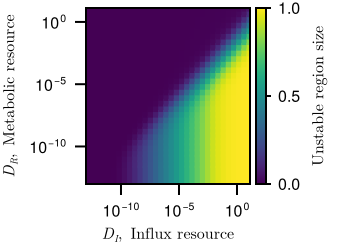

In [136]:
fig = Figure(;
    size=(double_col_width * 0.25, double_col_width * 0.18),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 4.)
)
ax = Axis(fig[1,1];
    # aspect=DataAspect(),
    xlabel=L"D_I,\enspace\text{Influx resource}",
    ylabel=L"D_R,\enspace\text{Metabolic resource}",
    xscale=log10,
    yscale=log10,
)

hm = heatmap!(ax, DIs, DRs, nprops;
)

Colorbar(fig[1,2], hm;
    label=L"\text{Unstable region size}",
    size=5.,
    ticksize=2.,
)

colgap!(fig.layout, 3.)

Makie.save("../../figures/fig2/diffusions_heatmap.pdf", fig)

fig

# Changing both DI and DR together

In [94]:
Ds = 10 .^ range(-12, 1, 20)

logKs = range(-0.5, 3, 100)
ls = range(0., 1., 100)

D_props = []
for D in Ds
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m=1.,
                    l=l,
                    k=0.,
                    c=1.,
                    d=1.,
                );
                DN=1e-12,
                DI=D,
                DR=D,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    num_unstable = count(x->(x == 3) || (x == 13), codes)
    push!(D_props, num_unstable / length(codes))
end

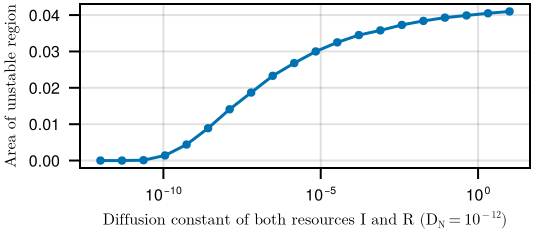

In [95]:
fig = Figure(;
    size=(double_col_width * 0.4, double_col_width * 0.17),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 2.)
)
ax = Axis(fig[1,1];
    ylabel=L"\text{Area of unstable region}",
    xlabel=L"\text{Diffusion constant of both resources $I$ and $R$ ($D_N = 10^{-12}$)}",
    xscale=log10,
)

scatterlines!(ax, Ds, D_props)

Makie.save("../../figures/fig2/DI_DR_diffusionplot.pdf", fig)

fig